# Cartesian FFT debug

We have noticed a constant phase shift between the results of the cartesian and spherical propagators. We would like to investigate it further in this dedicated notebook. 

The goal is to double check that the result is correct for a few pairs on input / Fourier transform output. 

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..')) + '/src/'
if module_path not in sys.path:
    sys.path.insert(0, module_path)
import numpy as np
from matplotlib import pyplot as plt

import torch
from pupil import ScalarCartesianPupil, ScalarPolarPupil, VectorialCartesianPupil, VectorialPolarPupil
from propagator import ScalarCartesianPropagator, ScalarPolarPropagator
from torch.fft import fft2, fftshift, ifftshift
from utils.czt import custom_fft2, custom_ifft2

%load_ext autoreload
%autoreload 2

## Case 1: gaussian

### Analytic and using original Pytorch FFT

tensor(0.9980)
tensor(0.9980)
tensor(1.0000-6.2336e-16j)


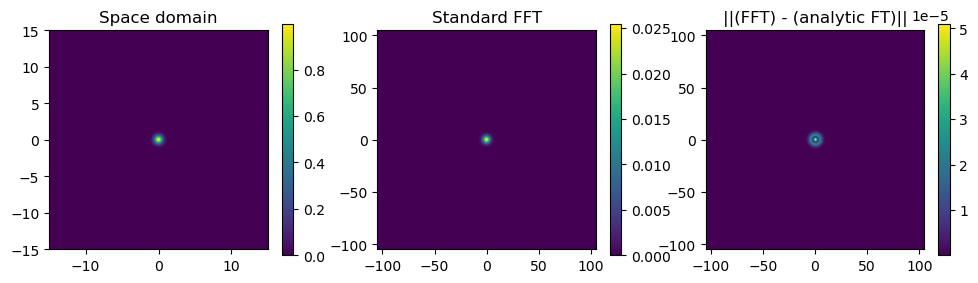

tensor(0.0020)


In [2]:
# Parameters
fov = 30
sigma = 0.4
n_pix = 1001  # must be odd

# space domain gaussian
x = torch.linspace(-fov/2, fov/2, n_pix)
dx = fov / n_pix
xx, yy = torch.meshgrid(x, x, indexing='ij')
object_gaussian = 1 / 2 / np.pi / sigma**2 * torch.exp(-(xx ** 2 + yy ** 2) / (2 * sigma**2))
print(torch.sum(object_gaussian) * dx ** 2)

# frequency domain gaussian, analytic
kx = torch.linspace(-2*np.pi/(2*dx), 2*np.pi/(2*dx), n_pix)
dk = 2*np.pi / fov
kxx, kyy = torch.meshgrid(kx, kx, indexing='ij')
fourier_sigma = 1 / sigma
fourier_gaussian = 1 / 2 / np.pi / fourier_sigma**2 * torch.exp(-(kxx ** 2 + kyy ** 2) / (2 * fourier_sigma**2))
print(torch.sum(fourier_gaussian) * dk ** 2)

# numerical FFT
numerical_fourier_gaussian = fftshift(fft2(ifftshift(object_gaussian))) * dx**2 / 2 / np.pi * sigma**2
print(torch.sum(numerical_fourier_gaussian) * dk**2)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(object_gaussian, extent=[x[0], x[-1], x[0], x[-1]])
plt.title("Space domain")
plt.colorbar()
plt.subplot(132)
plt.imshow(torch.abs(numerical_fourier_gaussian), extent=[kx[0], kx[-1], kx[0], kx[-1]])
plt.title("Standard FFT")
plt.colorbar()
plt.subplot(133)
plt.imshow(torch.abs(numerical_fourier_gaussian - fourier_gaussian), extent=[kx[0], kx[-1], kx[0], kx[-1]])
plt.title("||(FFT) - (analytic FT)||")
plt.colorbar()
plt.show()

print(torch.max(torch.abs(numerical_fourier_gaussian - fourier_gaussian)) / torch.max(fourier_gaussian))

We see that the analytic and the numerical PSFs match with less than 1% discrepancy. 

### Zooming in using CZT

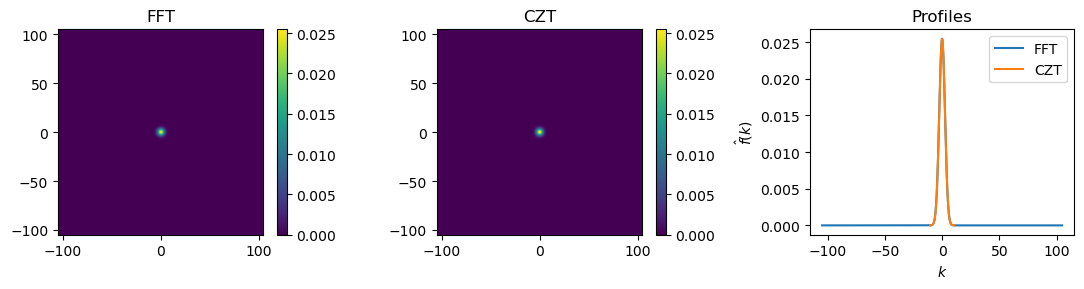

In [3]:
k_start = -torch.pi * 0.1
k_end   =  torch.pi * 0.1
# Renormalize the k-space
ks = ((kx - kx[0]) / (kx[-1] - kx[0]) * (k_end - k_start) + k_start) * kx[-1] / torch.pi

zoomed_fourier_gaussian = custom_fft2(object_gaussian, 
                        shape_out=object_gaussian.shape,
                        k_start=k_start, 
                        k_end=k_end, 
                        norm="backward", 
                        fftshift_input=True, 
                        include_end=True) * dx**2 / 2 / np.pi * sigma**2

vmin = torch.minimum(torch.min(torch.abs(fourier_gaussian)), torch.min(torch.abs(zoomed_fourier_gaussian)))
vmax = torch.maximum(torch.max(torch.abs(fourier_gaussian)), torch.max(torch.abs(zoomed_fourier_gaussian)))

plt.figure(figsize=(11,3))

plt.subplot(131)
plt.title("FFT")
plt.imshow(torch.abs(fourier_gaussian), extent=[kx[0], kx[-1], kx[0], kx[-1]], vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(132)
plt.title("CZT")
plt.imshow(torch.zeros_like(fourier_gaussian, dtype=float), extent=[kx[0], kx[-1], kx[0], kx[-1]], vmin=vmin, vmax=vmax)
plt.pcolormesh(*torch.meshgrid(ks, ks, indexing='ij'), torch.abs(zoomed_fourier_gaussian), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlim([kx[0], kx[-1]])
plt.ylim([kx[0], kx[-1]])

plt.subplot(133)
plt.title("Profiles")
plt.plot(kx, fourier_gaussian[n_pix//2].abs(), label='FFT')
plt.plot(ks, zoomed_fourier_gaussian[n_pix//2].abs(), label='CZT')
plt.ylabel(r"$\hat{f}(k)$")
plt.xlabel(r"$k$")
plt.legend()
plt.tight_layout()
plt.show()

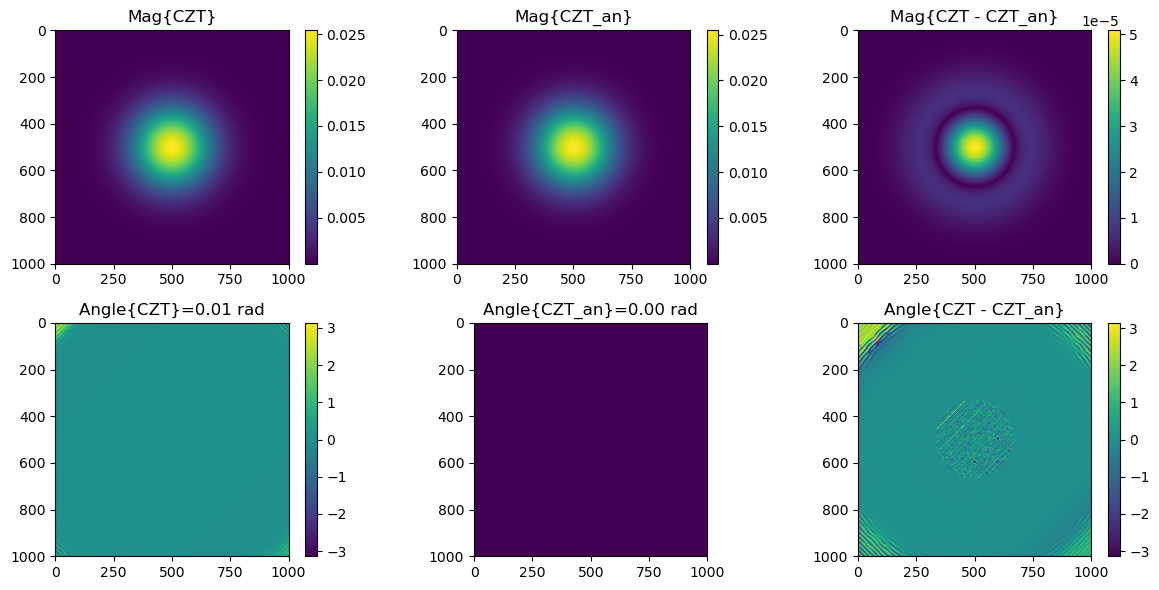

In [4]:
ksx, ksy = torch.meshgrid(ks, ks, indexing='ij')
analytic_solution = 1 / 2 / np.pi / fourier_sigma**2 * torch.exp(-(ksx ** 2 + ksy ** 2) / (2 * fourier_sigma**2))

plt.figure(figsize=(12,6))
plt.subplot(231)
plt.title("Mag{CZT}")
plt.imshow(torch.abs(zoomed_fourier_gaussian))
plt.colorbar()
plt.subplot(234)
plt.title("Angle{CZT}=" + f"{torch.angle(zoomed_fourier_gaussian).mean():.2f} rad")
plt.imshow(torch.angle(zoomed_fourier_gaussian))
plt.colorbar()

plt.subplot(232)
plt.title("Mag{CZT_an}")
plt.imshow(torch.abs(analytic_solution))
plt.colorbar()
plt.subplot(235)
plt.title("Angle{CZT_an}=" + f"{torch.angle(analytic_solution).mean():.2f} rad")
plt.imshow(torch.angle(analytic_solution))
# plt.colorbar()

plt.subplot(233)
plt.title("Mag{CZT - CZT_an}")
plt.imshow(torch.abs(torch.abs(zoomed_fourier_gaussian) - torch.abs(analytic_solution)))
plt.colorbar()
plt.subplot(236)
plt.title("Angle{CZT - CZT_an}")
plt.imshow(torch.angle(zoomed_fourier_gaussian - analytic_solution))
plt.colorbar()
plt.tight_layout()

The zoomed versions also match. 

### With the library

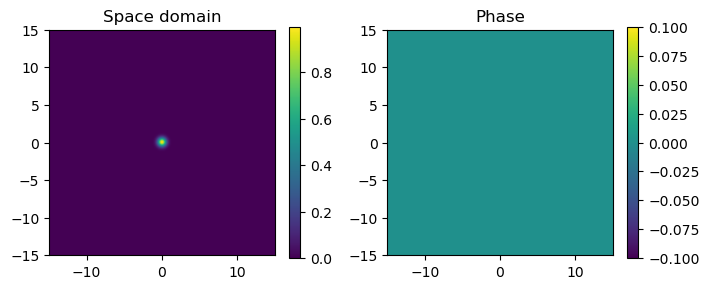

In [5]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(torch.abs(object_gaussian), extent=[x[0], x[-1], x[0], x[-1]])
plt.title("Space domain")
plt.colorbar()
plt.subplot(122)
plt.imshow(torch.angle(object_gaussian), extent=[x[0], x[-1], x[0], x[-1]])
plt.title("Phase")
plt.colorbar()
plt.show()

0.08227848101265822


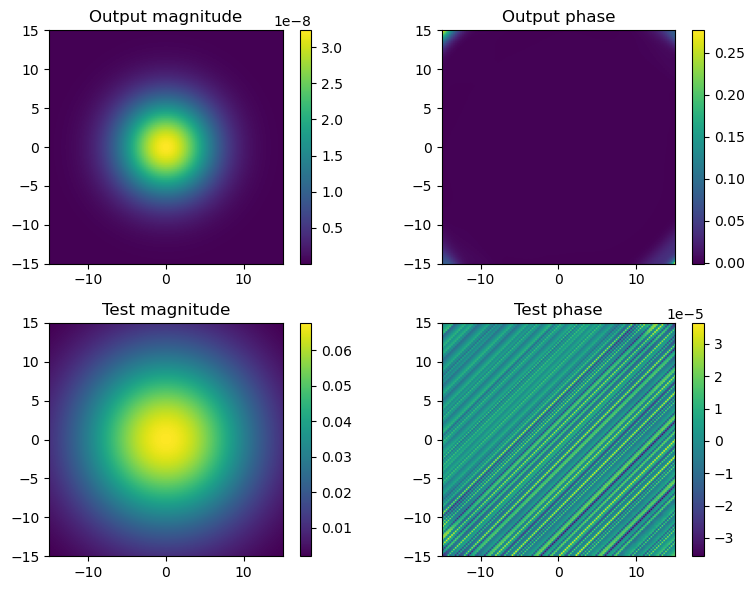

In [6]:
pupil = ScalarCartesianPupil(init_field=object_gaussian, n_pix_pupil=n_pix)
propagator = ScalarCartesianPropagator(pupil=pupil, fov=3e4)
output_field = propagator.compute_focus_field()

zoom_factor = 0.045 # propagator.zoom_factor
test = custom_ifft2(object_gaussian, shape_out=(128,128), k_start=-zoom_factor*torch.pi, k_end=zoom_factor*torch.pi, norm='backward', fftshift_input=True, include_end=True)

plt.figure(figsize=(8,6))
plt.subplot(221)
plt.imshow(torch.abs(output_field.squeeze()), extent=[x[0], x[-1], x[0], x[-1]])
plt.colorbar()
plt.title("Output magnitude")
plt.subplot(222)
plt.imshow(torch.angle(output_field.squeeze()), extent=[x[0], x[-1], x[0], x[-1]])
plt.colorbar()
plt.title("Output phase")
plt.subplot(223)
plt.imshow(torch.abs(test.squeeze()), extent=[x[0], x[-1], x[0], x[-1]])
plt.colorbar()
plt.title("Test magnitude")
plt.subplot(224)
plt.imshow(torch.angle(test.squeeze()), extent=[x[0], x[-1], x[0], x[-1]])
plt.colorbar()
plt.title("Test phase")
plt.tight_layout()

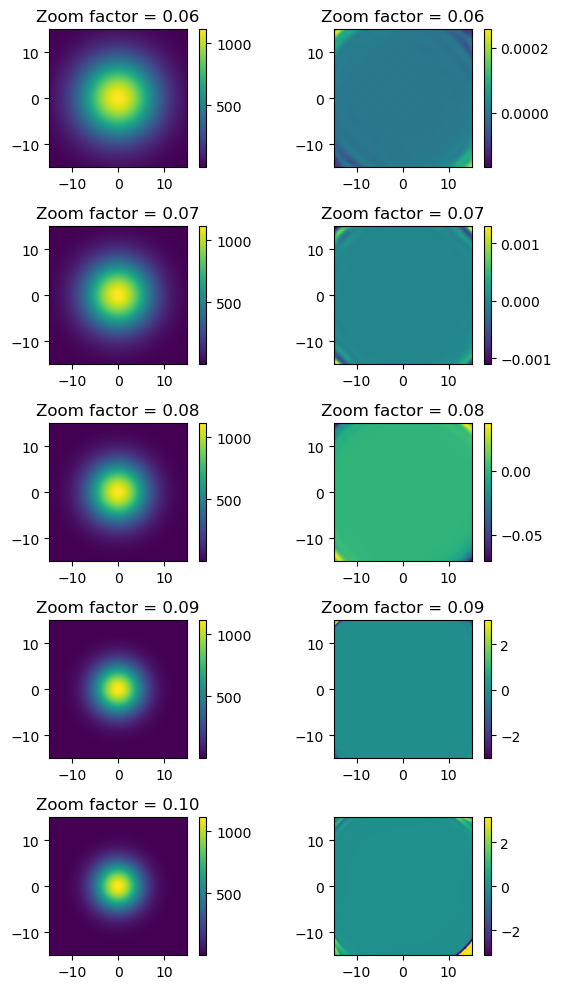

In [7]:
zoom_factor = 0.06 # propagator.zoom_factor
test6 = custom_fft2(object_gaussian, shape_out=(256,256), k_start=-zoom_factor*torch.pi, k_end=zoom_factor*torch.pi, norm='backward', fftshift_input=True, include_end=True)

zoom_factor = 0.07
test7 = custom_fft2(object_gaussian, shape_out=(256,256), k_start=-zoom_factor*torch.pi, k_end=zoom_factor*torch.pi, norm='backward', fftshift_input=True, include_end=True)

zoom_factor = 0.08
test8 = custom_fft2(object_gaussian, shape_out=(256,256), k_start=-zoom_factor*torch.pi, k_end=zoom_factor*torch.pi, norm='backward', fftshift_input=True, include_end=True)

zoom_factor = 0.0955
test9 = custom_fft2(object_gaussian, shape_out=(256,256), k_start=-zoom_factor*torch.pi, k_end=zoom_factor*torch.pi, norm='backward', fftshift_input=True, include_end=True)

zoom_factor = 0.1
test10 = custom_fft2(object_gaussian, shape_out=(256,256), k_start=-zoom_factor*torch.pi, k_end=zoom_factor*torch.pi, norm='backward', fftshift_input=True, include_end=True)

plt.figure(figsize=(6,10))
plt.subplot(521)
plt.imshow(torch.abs(test6.squeeze()), extent=[x[0], x[-1], x[0], x[-1]])
plt.colorbar()
plt.title("Zoom factor = 0.06")
plt.subplot(522)
plt.imshow(torch.angle(test6.squeeze()), extent=[x[0], x[-1], x[0], x[-1]])
plt.colorbar()
plt.title("Zoom factor = 0.06")
plt.subplot(523)
plt.imshow(torch.abs(test7.squeeze()), extent=[x[0], x[-1], x[0], x[-1]])
plt.colorbar()
plt.title("Zoom factor = 0.07")
plt.subplot(524)
plt.imshow(torch.angle(test7.squeeze()), extent=[x[0], x[-1], x[0], x[-1]])
plt.colorbar()
plt.title("Zoom factor = 0.07")
plt.subplot(525)
plt.imshow(torch.abs(test8.squeeze()), extent=[x[0], x[-1], x[0], x[-1]])
plt.colorbar()
plt.title("Zoom factor = 0.08")
plt.subplot(526)
plt.imshow(torch.angle(test8.squeeze()), extent=[x[0], x[-1], x[0], x[-1]])
plt.colorbar()
plt.title("Zoom factor = 0.08")
plt.subplot(527)
plt.imshow(torch.abs(test9.squeeze()), extent=[x[0], x[-1], x[0], x[-1]])
plt.colorbar()
plt.title("Zoom factor = 0.09")
plt.subplot(528)
plt.imshow(torch.angle(test9.squeeze()), extent=[x[0], x[-1], x[0], x[-1]])
plt.colorbar()
plt.title("Zoom factor = 0.09")
plt.subplot(529)
plt.imshow(torch.abs(test10.squeeze()), extent=[x[0], x[-1], x[0], x[-1]])
plt.colorbar()
plt.title("Zoom factor = 0.10")
plt.subplot(5,2,10)
plt.imshow(torch.angle(test10.squeeze()), extent=[x[0], x[-1], x[0], x[-1]])
plt.colorbar()
plt.tight_layout()
plt.show()